In [ ]:
!pip install opendatasets

In [ ]:
# Import libraries
import pandas as pd
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od
import glob
import os
import pathlib
import PIL
from PIL import Image
import PIL.Image
import PIL.ImageShow
from google.colab.patches import cv2_imshow
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.layers import MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers.legacy import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from keras.models import Sequential
from tensorflow.compat.v1.keras.layers import BatchNormalization
from keras.layers import Conv2D
import matplotlib.pyplot as plt

In [ ]:
# Download datset from Kaggle to notebook directory
# https://www.geeksforgeeks.org/how-to-import-kaggle-datasets-directly-into-google-colab/
od.download('https://www.kaggle.com/datasets/responsibleailab/crop-disease-ghana')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pkhanna2
Your Kaggle Key: ··········


100%|██████████| 18.7G/18.7G [04:00<00:00, 83.3MB/s]


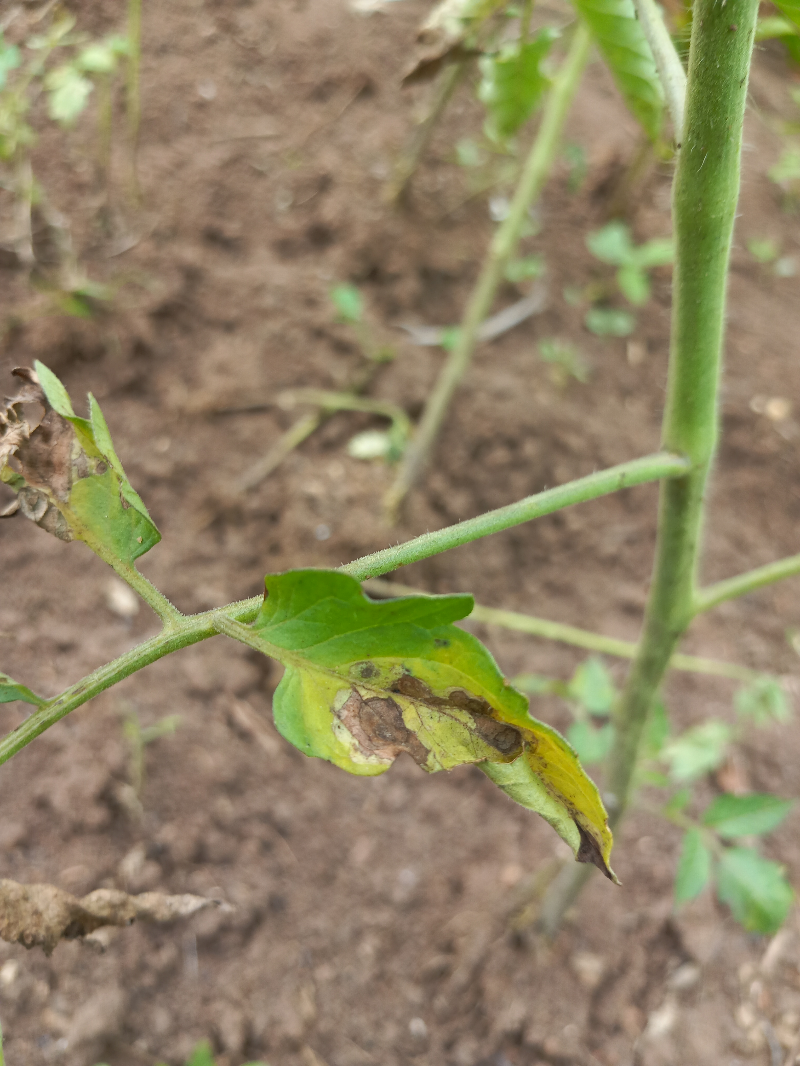

In [ ]:
# Print out test image
test_img = '/content/crop-disease-ghana/input/Tomato/Tomato__Early_Blight/images/20230518_134246.jpg'
test_img = cv2.imread(test_img)
#cv2_imshow(test_img)

def display_image(test_img):
    h, w = test_img.shape[0:2]
    neww = 800
    newh = int(neww*(h/w))
    test_img = cv2.resize(test_img, (neww, newh))
    cv2_imshow(test_img)
    cv2.waitKey(0)

display_image(test_img)

In [ ]:
# Show files in directory
os.listdir('/content/crop-disease-ghana/input')

['Corn',
 'label_map.pbtxt',
 'label_map.json',
 'catyegory_index.pbtxt',
 'Pepper',
 'label_map.txt',
 'dataset_labels.csv',
 'Tomato']

In [ ]:
# Read csv file with data labels
labels_df = pd.read_csv('/content/crop-disease-ghana/input/dataset_labels.csv')
labels_df.head()

filename                    disease  crop  width  height  depth  \
0  20230524_104642.jpg  Corn Cercospora Leaf Spot  Corn   4080    1836      3   
1  20230524_104642.jpg  Corn Cercospora Leaf Spot  Corn   4080    1836      3   
2  20230524_104642.jpg  Corn Cercospora Leaf Spot  Corn   4080    1836      3   
3  20230524_104642.jpg  Corn Cercospora Leaf Spot  Corn   4080    1836      3   
4  20230524_104642.jpg  Corn Cercospora Leaf Spot  Corn   4080    1836      3   

          xmin         ymin         xmax         ymax  \
0  2052.653343   695.836619  2210.117161   785.809054   
1  1110.682288   901.086237  1228.780152   982.623756   
2  1647.746382   912.332791  1791.150930  1002.305226   
3  2491.302550  1275.034169  2589.717436  1367.818243   
4  3326.423156  1255.352699  3410.778773  1339.701857   

                                            ann_path  \
0  input\Corn\Corn__Cercospora_Leaf_Spot\annotati...   
1  input\Corn\Corn__Cercospora_Leaf_Spot\annotati...   
2  input\Corn\Corn__Cercospora_Leaf_Spot\annotati...   
3  input\Corn\Corn__Cercospora_Leaf_Spot\annotati...   
4  input\Corn\Corn__Cercospora_Leaf_Spot\annotati...   

                                            img_path  
0  input\Corn\Corn__Cercospora_Leaf_Spot\images\2...  
1  input\Corn\Corn__Cercospora_Leaf_Spot\images\2...  
2  input\Corn\Corn__Cercospora_Leaf_Spot\images\2...  
3  input\Corn\Corn__Cercospora_Leaf_Spot\images\2...  
4  input\Corn\Corn__Cercospora_Leaf_Spot\images\2...

In [ ]:
# Create new column combining width and height column
labels_df['shape'] = 0
shape_lst = []
for i in range(len(labels_df)):
  shape_lst.append((labels_df['width'][i],labels_df['height'][i]))

labels_df['shape'] = shape_lst
labels_df['shape'].value_counts()

(4032, 3024)    19548
(4080, 1836)    13500
(1920, 1280)    12418
(4080, 3060)     9007
(720, 480)       1473
(4000, 3000)     1123
(6720, 4480)      552
(1920, 2560)      428
(2560, 1920)      210
(2576, 1932)      102
Name: shape, dtype: int64

In [ ]:
# Labels for categories
f = open('/content/crop-disease-ghana/input/label_map.json')
label_json = json.load(f)
label_json

{'Corn Cercospora Leaf Spot': 1,
 'Corn Common Rust': 2,
 'Corn Healthy': 3,
 'Corn Streak': 4,
 'Corn Northern Leaf Blight': 5,
 'Pepper Leaf Curl': 6,
 'Pepper Cercospora': 7,
 'Pepper Leaf Blight': 8,
 'Pepper Bacterial Spot': 9,
 'Pepper Leaf Mosaic': 10,
 'Pepper Healthy': 11,
 'Pepper Fusarium': 12,
 'Pepper Septoria': 13,
 'Pepper Late Blight': 14,
 'Pepper Early Blight': 15,
 'Tomato Late Blight': 16,
 'Tomato Early Blight': 17,
 'Tomato Bacterial Spot': 18,
 'Tomato Septoria': 19,
 'Tomato Fusarium': 20,
 'Tomato Leaf Curl': 21,
 'Tomato Healthy': 22,
 'Tomato Mosaic': 23}

<Axes: xlabel='crop', ylabel='count'>

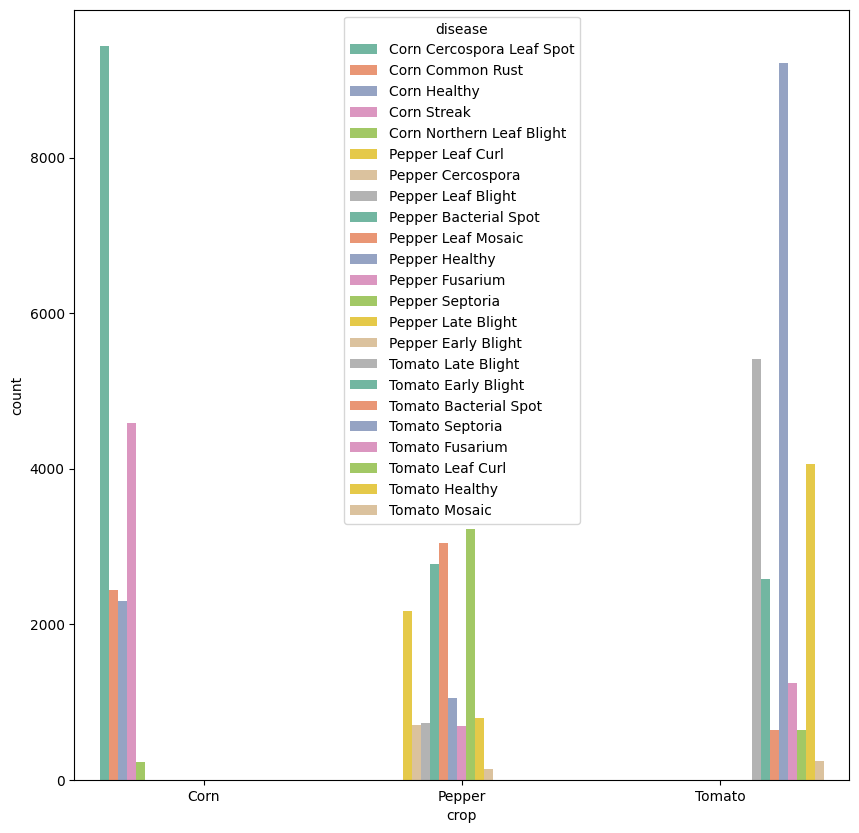

In [ ]:
# Crop type and disease distribution
plt.figure(figsize = (10,10))
sns.countplot(x = labels_df['crop'],hue = labels_df['disease'],palette = 'Set2')

In [ ]:
# Disease value counts
labels_df['disease'].value_counts()

Corn Cercospora Leaf Spot    9431
Tomato Septoria              9211
Tomato Late Blight           5408
Corn Streak                  4591
Tomato Healthy               4066
Pepper Septoria              3222
Pepper Leaf Mosaic           3047
Pepper Bacterial Spot        2780
Tomato Early Blight          2585
Corn Common Rust             2434
Corn Healthy                 2304
Pepper Leaf Curl             2175
Tomato Fusarium              1238
Pepper Healthy               1049
Pepper Late Blight            792
Pepper Leaf Blight            730
Pepper Cercospora             704
Pepper Fusarium               696
Tomato Leaf Curl              641
Tomato Bacterial Spot         639
Tomato Mosaic                 246
Corn Northern Leaf Blight     234
Pepper Early Blight           138
Name: disease, dtype: int64

### Looks like there is class imbalance. In order to address this problem, there should be a combination of resampling and data augmentation.

In [ ]:
# Create balanced dataset

df_balanced = pd.DataFrame(columns = labels_df.columns)
for i in np.unique(labels_df['disease']):
  df = labels_df[labels_df['disease']==i]
  samp = df.sample(n = 138)
  df_balanced = df_balanced.append(samp,ignore_index = True)

<ipython-input-17-d9dc1177704d>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_balanced = df_balanced.append(samp,ignore_index = True)


In [ ]:
df_balanced

filename                    disease    crop width height  \
0               2N8A1597.JPG  Corn Cercospora Leaf Spot    Corn  1920   1280   
1        20230525_112541.jpg  Corn Cercospora Leaf Spot    Corn  4080   1836   
2        20230525_111953.jpg  Corn Cercospora Leaf Spot    Corn  4080   1836   
3     20230526_103115(0).jpg  Corn Cercospora Leaf Spot    Corn  4080   1836   
4     20230526_114030(0).jpg  Corn Cercospora Leaf Spot    Corn  4080   1836   
...                      ...                        ...     ...   ...    ...   
3169           IMG_6267.jpeg            Tomato Septoria  Tomato  4032   3024   
3170           IMG_5326.jpeg            Tomato Septoria  Tomato  4032   3024   
3171           IMG_6378.jpeg            Tomato Septoria  Tomato  4032   3024   
3172            2N8A1268.JPG            Tomato Septoria  Tomato  1920   1280   
3173           IMG_5352.jpeg            Tomato Septoria  Tomato  4032   3024   

     depth         xmin         ymin         xmax         ymax  \
0        3   916.925466   402.474120   942.893375   422.324017   
1        3    88.385744  1080.458560   202.431866  1137.477193   
2        3  1926.119917  1235.671229  1993.604411  1305.962194   
3        3  1325.786164   889.446137  1465.492662  1086.160423   
4        3  1405.618449  1542.309491  1491.153040  1596.477193   
...    ...          ...          ...          ...          ...   
3169     3    42.451712  1572.238217   179.237489  1675.950307   
3170     3    86.784748   862.276991   185.213373   968.814379   
3171     3  1027.962622  2050.853582  1320.775357  2229.508768   
3172     3   967.693208   584.929742  1008.243560   667.956674   
3173     3   950.608941  2594.441633  1060.054282  2687.982903   

                                               ann_path  \
0      input\Corn\Corn__Streak\annotations\2N8A1597.xml   
1     input\Corn\Corn__Cercospora_Leaf_Spot\annotati...   
2     input\Corn\Corn__Cercospora_Leaf_Spot\annotati...   
3     input\Corn\Corn__Cercospora_Leaf_Spot\annotati...   
4     input\Corn\Corn__Cercospora_Leaf_Spot\annotati...   
...                                                 ...   
3169  input\Tomato\Tomato__Late_Blight\annotations\I...   
3170  input\Tomato\Tomato__Late_Blight\annotations\I...   
3171  input\Tomato\Tomato__Septoria\annotations\IMG_...   
3172  input\Tomato\Tomato__Late_Blight\annotations\2...   
3173  input\Tomato\Tomato__Late_Blight\annotations\I...   

                                               img_path         shape  
0           input\Corn\Corn__Streak\images\2N8A1597.JPG  (1920, 1280)  
1     input\Corn\Corn__Cercospora_Leaf_Spot\images\2...  (4080, 1836)  
2     input\Corn\Corn__Cercospora_Leaf_Spot\images\2...  (4080, 1836)  
3     input\Corn\Corn__Cercospora_Leaf_Spot\images\2...  (4080, 1836)  
4     input\Corn\Corn__Cercospora_Leaf_Spot\images\2...  (4080, 1836)  
...                                                 ...           ...  
3169  input\Tomato\Tomato__Late_Blight\images\IMG_62...  (4032, 3024)  
3170  input\Tomato\Tomato__Late_Blight\images\IMG_53...  (4032, 3024)  
3171  input\Tomato\Tomato__Septoria\images\IMG_6378....  (4032, 3024)  
3172  input\Tomato\Tomato__Late_Blight\images\2N8A12...  (1920, 1280)  
3173  input\Tomato\Tomato__Late_Blight\images\IMG_53...  (4032, 3024)  

[3174 rows x 13 columns]

In [ ]:
# Fix img path
loc_path = '/content/crop-disease-ghana/'
new_img = []
for txt in df_balanced['img_path']:
  n = loc_path + txt.replace('\\','/')
  new_img.append(n)
df_balanced['img_path'] = new_img
df_balanced['img_path'][0]

'/content/crop-disease-ghana/input/Corn/Corn__Streak/images/2N8A1597.JPG'

In [ ]:
# Fix annotation path
loc_path = '/content/crop-disease-ghana/'
new_ann = []
for txt in df_balanced['ann_path']:
  a = loc_path + txt.replace('\\','/')
  new_ann.append(a)
df_balanced['ann_path'] = new_ann
df_balanced['ann_path'][0]

'/content/crop-disease-ghana/input/Corn/Corn__Streak/annotations/2N8A1597.xml'

In [ ]:
df_balanced['disease'].value_counts()

Corn Cercospora Leaf Spot    138
Pepper Leaf Curl             138
Tomato Mosaic                138
Tomato Leaf Curl             138
Tomato Late Blight           138
Tomato Healthy               138
Tomato Fusarium              138
Tomato Early Blight          138
Tomato Bacterial Spot        138
Pepper Septoria              138
Pepper Leaf Mosaic           138
Pepper Leaf Blight           138
Corn Common Rust             138
Pepper Late Blight           138
Pepper Healthy               138
Pepper Fusarium              138
Pepper Early Blight          138
Pepper Cercospora            138
Pepper Bacterial Spot        138
Corn Streak                  138
Corn Northern Leaf Blight    138
Corn Healthy                 138
Tomato Septoria              138
Name: disease, dtype: int64

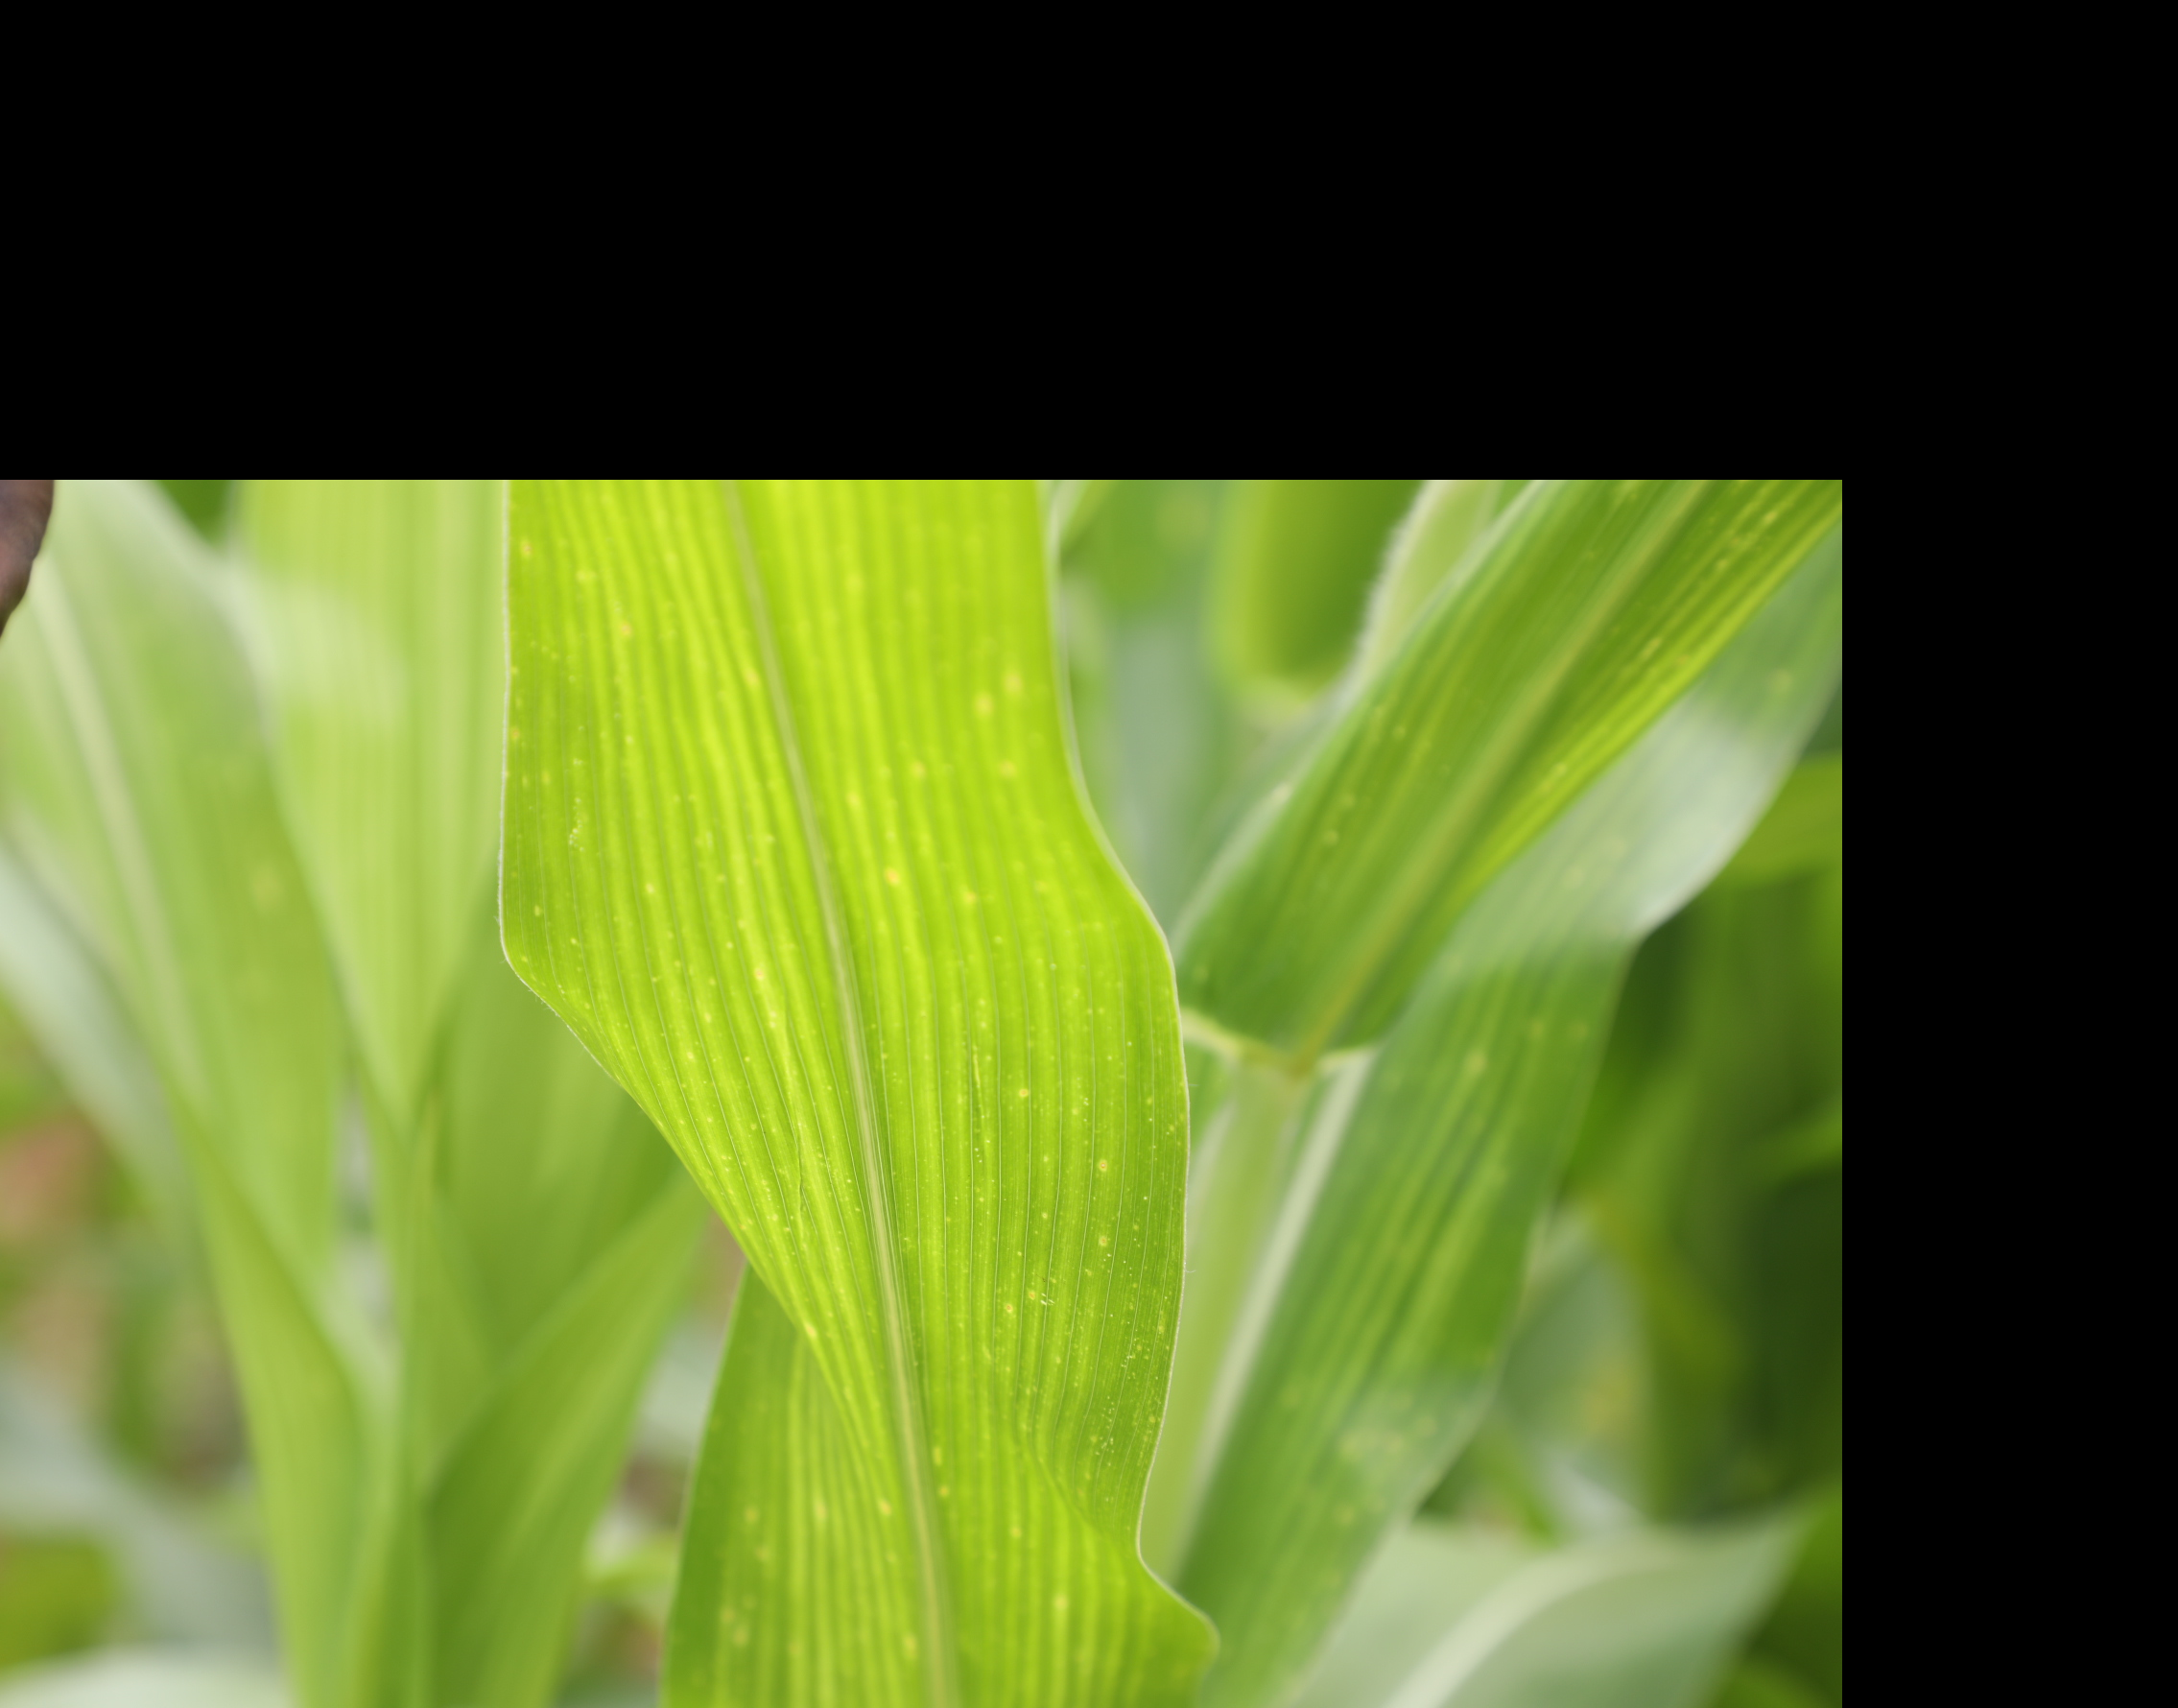

In [ ]:
# Define padding function
# Use this tutorial as a guide:
# https://note.nkmk.me/en/python-pillow-add-margin-expand-canvas/
def pad_img(im,top, right, bottom =0, left = 0, color = (0,0,0)):

    photo = Image.open(im)
    size = photo.size
    new_width = size[0] + right + left
    new_height = size[1] + top + bottom
    result = Image.new(photo.mode, (new_width, new_height), color)
    result.paste(photo, (left, top))
    return result
# Test out function
pad_img(df_balanced['img_path'][0],500,350)

In [ ]:
width=256
height=256
depth= epoch_= 25
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
#root_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/'
INIT_LR = 1e-3


In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
image_list, label_list = [], []
indx=0
try:
  for img_dir in df_balanced['img_path']:
    #img_dir= f"{root_dir}/{plant_folder}/{plant_disease_folder}/{image}"
    if img_dir.endswith(".jpg") == True or img_dir.endswith(".JPG") == True:
        image_list.append(convert_image_to_array(img_dir))
        label_list.append(df_balanced['disease'][indx])
        indx=indx+1
except Exception as e:
  print(f"Error : {e}")

In [ ]:
print(len(image_list))
print(len(label_list))

2086
2086


In [ ]:
label_binarizer = LabelBinarizer()
if label_list is not None:
  image_labels = label_binarizer.fit_transform(label_list)
  pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
  n_classes = len(label_binarizer.classes_)

In [ ]:
print(label_binarizer.classes_)

['Corn Cercospora Leaf Spot' 'Corn Common Rust' 'Corn Healthy'
 'Corn Northern Leaf Blight' 'Corn Streak' 'Pepper Bacterial Spot'
 'Pepper Cercospora' 'Pepper Early Blight' 'Pepper Fusarium'
 'Pepper Healthy' 'Pepper Late Blight' 'Pepper Leaf Blight'
 'Pepper Leaf Curl' 'Pepper Leaf Mosaic' 'Pepper Septoria'
 'Tomato Bacterial Spot']


In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(np_image_list, image_labels, test_size=0.5, random_state = 75)

In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")

In [ ]:
model = Sequential()
inputShape = (height, width, 3)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (3, height, width)
    chanDim = 1

In [ ]:
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [ ]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / epoch_)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [ ]:
history = model.fit_generator(
    aug.flow(train_x, train_y, batch_size=BS),
    validation_data=(test_x, test_y),
    steps_per_epoch=len(train_x) // BS,
    epochs=epoch_, verbose=1
    )

<ipython-input-99-4d367541d9f5>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/25
32/32 [==============================] - 340s 11s/step - loss: 0.7765 - accuracy: 0.0979 - val_loss: 0.6421 - val_accuracy: 0.0681
Epoch 2/25
32/32 [==============================] - 319s 10s/step - loss: 0.5150 - accuracy: 0.1543 - val_loss: 0.7508 - val_accuracy: 0.0709
Epoch 3/25
32/32 [==============================] - 318s 10s/step - loss: 0.2879 - accuracy: 0.1790 - val_loss: 0.8279 - val_accuracy: 0.0662
Epoch 4/25
 1/32 [..............................] - ETA: 4:43 - loss: 0.2523 - accuracy: 0.1562

In [ ]:
im = convert_image_to_array(img)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)

In [ ]:
result = model.predict(npp_image)
print(result)
itemindex = np.where(result == np.max(result))
print("Probability: " + str(np.max(result)) + "\n" + label_binarizer.classes_[itemindex[1][0]])

In [ ]:
image = Image.open(img)
plt.imshow(image)
plt.axis('off')
plt.title("Predicted class: " + label_binarizer.classes_[itemindex[1][0]])
plt.show()

In [ ]:
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")